In [1]:
# first, execute pip installs to ensure we have the correct packages
!pip install matplotlib==3.4.1
!pip install pandas==1.2.4

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import datetime as dt

# %matplotlib

In [3]:
# Read data from csv file.  Assumes that data is in two columns: datetime and pressure.
# Datetime values are assumed to be in the form: '%m/%d/%Y %H:%M'
# Returns two lists:  first list is datetimes, second list is pressures
def generateData():
    plungerData = pd.read_csv("../src/static/data/casing.csv")
    times = plungerData.iloc[:, 0].tolist()
    pressures = plungerData.iloc[:, 1].tolist()
    return times, pressures

The data we will be using (casing1.csv) has 2 columns timestamp and pressure.  This data has already been refactored. If you wish to look at the non-refactored data, open file static/data/casing_NotRefactored.csv.  The dataset is from a gas pump that is slowly failing overtime.  Let's plot this data to see what it looks like.  Can we see an anomaly in the visible data?

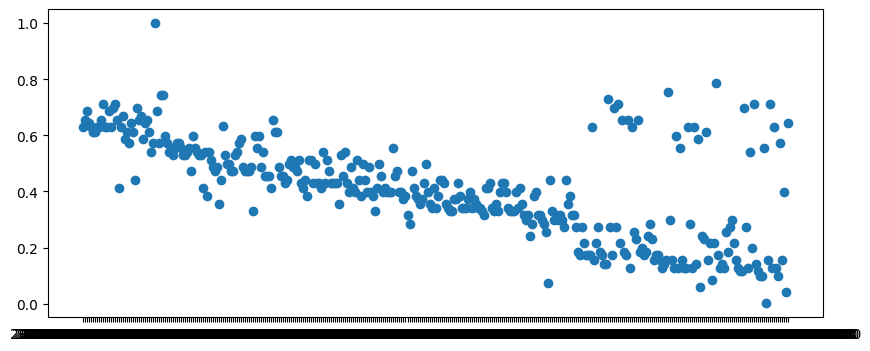

In [4]:
# plot the dataset to see what it looks like
times, pressures = generateData()
fig = pl.figure()
fig.set_figwidth(10)
fig.set_figheight(4)
pl.scatter(times, pressures)
pl.show()

We can see from the above plot that the pressure decreases over time and towards the end we observe some
pressure points that have extremely high values.  This could be an anomaly but how do 
we quantify these points?  

What we can do is perform a linear regression.  From the linear regression we can take the percent difference 
from the regression line and plot that line over our points.  Any lines extending beyond a certain distance from 
our points we can then label as 'an anomaly'

In [5]:
# Calculate the per cent difference between each data value and its corresponding
# value as predicted by the regression line given by regSlope and regIntersept
# Returns values as a numpy array
def calculatePerCentDiffs(xDataVals, yDataVals, regSlope, regIntersept):
    yErrors = []
    for point in zip(xDataVals, yDataVals):
        regY = regSlope * point[0] + regIntersept
        yErrors.append(100 * (point[1] - regY) / point[1])
    return np.array(yErrors)

In [6]:
# Calculate the per cent difference between one data value and its corresponding
# value as predicted by the regression line given by regSlope and regIntersept
def calculatePerCentDiff(xDataVal, yDataVal, regSlope, regIntersept):
    regY = regSlope * xDataVal + regIntersept
    return 100 * (yDataVal - regY) / regY

In [7]:
# create main function in which we set the anomaly standard deviation, plot window size, and a simulated pause to
# slow down the plotting of the anomaly.


def main():
    # Define anomaly as greater than anomalyDtdDevFactor * StandardDev
    anomalyStdDevFactor = 4
    # Define datetime window size
    datetimeWindowSize = 43
    # Define simulation pause in seconds
    simPause = 0.000001
    # Get data as two numpy arrays: xvals and yvals
    xStrDates, yVals = generateData()

    # Convert dates as strings to dates as datetime.datetime values
    dates_list = [dt.datetime.strptime(date, "%Y-%m-%d %H:%M:%S") for date in xStrDates]
    # Convert list of datetime.datetime values to ndarray of
    xVals = mdates.date2num(dates_list)

    # The Graph axis ax1 plots pressure values
    # The Graph axis ax2 plots pressure deviation as a per cent
    fig, ax1 = pl.subplots()
    ax2 = ax1.twinx()
    fig.set_size_inches(15, 5)
    # Simulate real time plotting by adding one point at a time to the current
    # data set and plot the data up to that point
    realTimeX = []
    realTimeY = []

    ax1.set_ylim(0, 1)
    ax1.set_xlabel("Time Units")
    ax1.set_ylabel("Pressure")

    ax2.set_ylabel(" % Deviation From Regression Line", color="g")
    ax2.set_ylim(-100, 100)

    pl.xlim(xVals[0], xVals[0] + datetimeWindowSize)

    xOld = 0
    yPerCentDiffOld = 0

    plotColor = "g"
    # Iterate thru all data, adding one point per iteration.  The lists, realTimeX and realTimeY start as empty and one
    # data point is added during each iteration. As each point is added, all points that have been added are displayed on graph.
    # This simulates real time data being added to the current graph.
    for x, y in zip(xVals, yVals):
        regress_plot_size = 30
        # These two variables hold the learning set data
        realTimeX.append(x)
        realTimeY.append(y)
        xNew = x
        # Wait for 6 points to be collected before calculating stats
        if len(realTimeX) > 10:
            # Do not calculate stats on present point.  It may be an anomaly.
            calcX = realTimeX[:-1]
            calcY = realTimeY[:-1]

            fit = np.polyfit(np.array(calcX), np.array(calcY), deg=1)

            # Calculate std and mean
            yPerCentDiffs = calculatePerCentDiffs(calcX, calcY, fit[0], fit[1])
            std = np.std(yPerCentDiffs)
            mean = np.mean(yPerCentDiffs)

            # Calculate percent diff for current point for plotting
            yPerCentDiff = calculatePerCentDiff(x, y, fit[0], fit[1])

            # If the yPerCentDiff is outside anomalyStdDevFactor*std range, remove it from the realTime
            # data so that the anomaly will not be included in the regression line
            # and not included in the calculation for std and mean.
            if (yPerCentDiff < mean - anomalyStdDevFactor * std) or (
                yPerCentDiff > mean + anomalyStdDevFactor * std
            ):
                plotColor = "r"
                # print("Pop anomaly")
                realTimeX.pop()
                realTimeY.pop()

            yPerCentDiffNew = yPerCentDiff
            # print(xOld, xNew, yPerCentDiffOld, yPerCentDiffNew, anomalyStdDevFactor*std,plotColor)

            if xOld > 0:
                ax2.plot(
                    [xOld, xNew], [yPerCentDiffOld, yPerCentDiffNew], color=plotColor
                )
                ax2.plot(
                    [xVals[0], xVals[len(xVals) - 1]],
                    [0, 0],
                    color="tab:blue",
                    linewidth=0.5,
                )
                # ax2.plot([17035, 17075], [0,0], color='tab:blue')
                X_as_numpy = np.array(calcX)
                X_len = len(X_as_numpy)
                if X_len > regress_plot_size:
                    regress_start = X_len - regress_plot_size
                    ax1.plot(
                        calcX[regress_start : X_len - 1],
                        (fit[0] * np.array(calcX[regress_start : X_len - 1]) + fit[1]),
                        color="blue",
                    )

            xOld = xNew
            yPerCentDiffOld = yPerCentDiffNew
            plotColor = "g"

        # Plot pressure data
        ax1.scatter(x, y, color="black")
        # print(x)
        # print(y)
        # pl.pause(simPause)

    pl.savefig("anomaly2.png")
    pl.show()

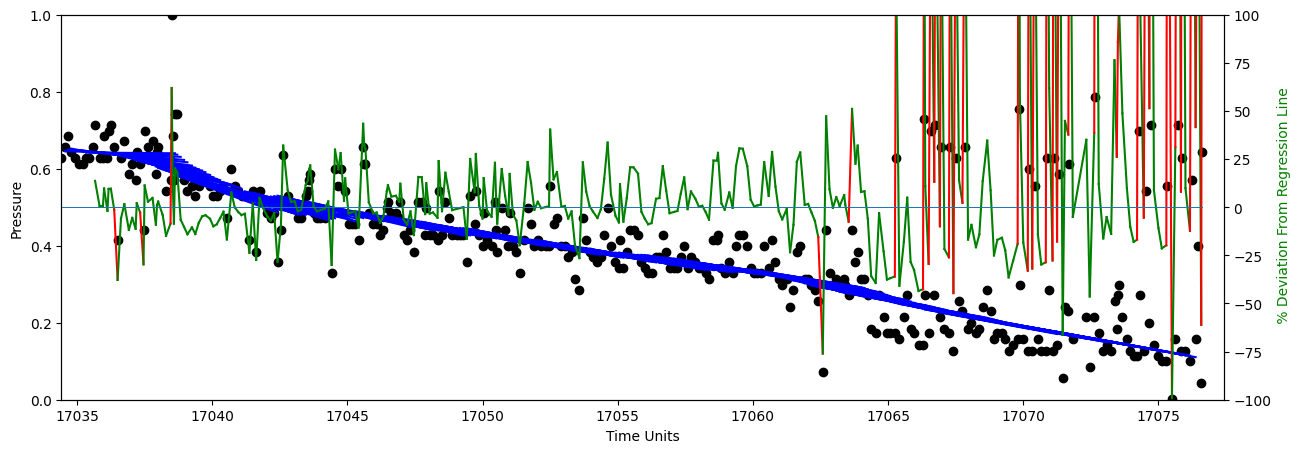

In [8]:
# Run main function which plots the points in black. The linear regression is identified by the blue line.  The Deviation from
# the regression line is colored green.  If the percent difference is outside of the anomaly standard deviation, we have an anomaly detected.
# Color the line red to denote a detected anomaly.  The plot will also be saved in the notebooks folder as anomaly2.png
# folder as

if __name__ == "__main__":
    main()